In [1]:
import os
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import trompy as tp
import pandas as pd
from scipy import stats

In [2]:
def get_number_cells (s2p_folder):
    iscell = np.load(os.path.join(s2p_folder, 'iscell.npy'))
    return sum(iscell[:,0])
    

In [3]:
def get_frames(events_file,s2p_length):
    df = pd.read_csv(events_file)

    pump_frames = list(df[df['Item1'] == 'pump_on']['Item2.Item2'])

    pump_frames=[frame for frame in pump_frames if frame < s2p_length-100] #removes event if too close to the end

    licks_frames = list (df[df['Item1']== 'Lick']['Item2.Item2'])
    
    licks_frames=[frame for frame in licks_frames if frame < s2p_length-100] #removes event if too close to the end
    
    return pump_frames, licks_frames

In [4]:
def filter_cell(x):

    t = np.arange(0,len(x)/10,0.1)
    filt = signal.butter(4, 1, 'low', fs=10, output='sos')
    filtered = signal.sosfilt(filt, x)
    
    return filtered
    

In [99]:
def get_activated_cells (s2p_folder,events_file):
    raw_F = np.load(os.path.join(s2p_folder, 'F.npy'))
    neu_F = np.load(os.path.join(s2p_folder, 'Fneu.npy'))
    iscell = np.load(os.path.join(s2p_folder, 'iscell.npy'))
#     stats=np.load(os.path.join(s2p_folder, 'stat.npy'), allow_pickle=True)
    
    s2p_length=len(raw_F[0,:])
    print(s2p_length)
    
    pump_frames, licks_frames= get_frames(events_file,s2p_length)
    
    cell_idx = [idx for idx,vals in enumerate(iscell) if vals[0]==1]
    
    activated_cells=0
    pump_activated_cells=[]
    pump_inhibited_cells=[]
    lick_activated_cells=[]
    lick_inhibited_cells=[]
    
    mean_lick_a_snips=[]
    mean_lick_i_snips=[]
    mean_pump_a_snips=[]
    mean_pump_i_snips=[]
    mean_snips=[]

    for i, cell in enumerate(cell_idx):
        x = raw_F[cell, :] - 0.7*(neu_F[cell, :])
#         x = raw_F[cell, :]
        x = (x - np.mean(x))/np.std(x)
        x = filter_cell(x)
        
        
        pump_snips = []
        pre=[]
        post=[]
        
        for p in pump_frames:
            pump_snips.append(x[p-50:p+100])
            pre.append(np.mean(x[p-50:p]))
            post.append(np.mean(x[p:p+50]))
        result_pump= stats.ttest_rel(pre, post)
        temp_pump_snips=np.mean(pump_snips, axis=0)
        
        
        
        p=result_pump[1]
        if (p < 0.05) and (np.mean(pre) < np.mean(post)): 
            pump_activated_cells.append(cell)
            mean_pump_a_snips.append(temp_pump_snips)
            
        if (p < 0.05) and (np.mean(pre) > np.mean(post)):
            pump_inhibited_cells.append(cell)
            mean_pump_i_snips.append(temp_pump_snips)    
        
        
        #get first lick in the trials 
        licks=[]
        for p in pump_frames: 
            temp=[]
            for l in licks_frames: 
                if l > p and l < p + 100: 
                    temp.append(l)                
            licks.append(temp)
            
        
        temp_lick=[]
        for trial in licks:
            if len(trial) > 0: 
                temp_lick.append(trial[:1])
        first_lick=[trial for sublist in temp_lick for trial in sublist] # List comprehention to make list of list into list of floats
        
        # snips and p-value of first lick in trial 
        lick_snips=[]
        pre_lick=[]
        post_lick=[]
        
        for p in first_lick:
            lick_snips.append(x[p-50:p+100])
            pre_lick.append(np.mean(x[p-50:p]))
            post_lick.append(np.mean(x[p:p+50]))
        lick_result= stats.ttest_rel(pre_lick, post_lick)
        temp_lick_snips=np.mean(lick_snips, axis=0)
        
        p=lick_result[1]
        if (p < 0.05) and (np.mean(pre_lick) < np.mean(post_lick)):  
            lick_activated_cells.append(cell)
            mean_lick_a_snips.append(temp_lick_snips)
        
        if (p < 0.05) and (np.mean(pre_lick) > np.mean(post_lick)):
            lick_inhibited_cells.append(cell)
            mean_lick_i_snips.append(temp_lick_snips)
    

    
    both_activated_cells=list(set(pump_activated_cells)& set(lick_activated_cells))
    both_inhibited_cells=list(set(pump_inhibited_cells)& set(lick_inhibited_cells))
    
    print('pump activated:',pump_activated_cells)
    print('pump inhibited:',pump_inhibited_cells)
    print('lick activated:',lick_activated_cells)
    print('lick inhibited:',lick_inhibited_cells)
    print('both activated:',both_activated_cells)
    print('both inhibited:', both_inhibited_cells)
    
    # Number of cells activated by pump or lick
    
    n_pump_a_only=len(pump_activated_cells)-len(both_activated_cells)
    n_lick_a_only=len(lick_activated_cells)-len(both_activated_cells)
    n_both_a=len(both_activated_cells)
    n_non_a=len(cell_idx)-n_pump_a_only-n_lick_a_only-n_both_a
    
    # Number of cells inhibited by pump or lick
    n_pump_i_only=len(pump_inhibited_cells)-len(both_inhibited_cells)
    n_lick_i_only=len(lick_inhibited_cells)-len(both_inhibited_cells)
    n_both_i=len(both_inhibited_cells)
    n_non_i=len(cell_idx)-n_pump_i_only-n_lick_i_only-n_both_i
    
    # Number of cells response to pump or lick 
    n_pump_r= n_pump_a_only+n_pump_i_only
    n_lick_r= n_lick_a_only+n_lick_i_only
    n_both_r= n_both_a + n_both_i
    n_non_r= len(cell_idx)-n_pump_a_only-n_pump_i_only-n_lick_a_only-n_lick_i_only-n_both_a-n_both_i
    
    print(n_pump_r,n_lick_r,n_both_r,n_non_r)
    print(len(cell_idx))
    
    sizes_a=[n_pump_a_only,n_lick_a_only,n_both_a,n_non_a]
    sizes_i= [n_pump_i_only,n_lick_i_only, n_both_i,n_non_i]
    sizes_r=[n_pump_r,n_lick_r,n_both_r,n_non_r]
    labels= 'Pump','Lick','Both','Neither'
    
    # pie chart for activated cells 
    f1, ax1 = plt.subplots()
    ax1.pie(sizes_a, labels=labels, autopct='%1.1f%%',
        startangle=90, colors=['green','red','yellow','dimgrey'])
    
    #pie chart for inhibited cells
    
    f2, ax1 = plt.subplots()
    ax1.pie(sizes_i, labels=labels, autopct='%1.1f%%',
        startangle=90, colors=['green','red','yellow','dimgrey'])
    
    #pie chart for responsive cells 
    
    f3, ax1 = plt.subplots()
    ax1.pie(sizes_r, labels=labels, autopct='%1.1f%%',
        startangle=90, colors=['green','red','yellow','dimgrey'])
    
    return mean_lick_a_snips, mean_lick_i_snips,mean_pump_a_snips,mean_pump_i_snips
    
  
#         Snips and p-value hit trials        
                
#         hit_snips=[]
#         pre_hit=[]
#         post_hit=[]
        
#         for p in hit: 
#             hit_snips.append(x[p-50:p+100])
#             pre_hit.append(np.mean(x[p-50:p]))
#             post_hit.append(np.mean(x[p:p+50]))
#         hit_result= stats.ttest_rel(pre_hit, post_hit)
        
#         #Snips and p-value missed trials
        
#         miss_snips=[]
#         pre_miss=[]
#         post_miss=[]
        
#         for p in miss: 
#             miss_snips.append(x[p-50:p+100])
#             pre_miss.append(np.mean(x[p-50:p]))
#             post_miss.append(np.mean(x[p:p+50]))
#         miss_result= stats.ttest_rel(pre_miss, post_miss)


## Casein PR 

In [100]:
animal="VGP302"
day="031"
date="20221110"
s2p_folder = "C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\Processed\\VGP_procd_data_22-12-05\\sub-{}\\ses-{}".format(animal, day)
events_file = "C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\Processed\\behav\\sub-{0}\\ses-{1}-{2}\\sub-{0}_ses-{1}_events.csv".format(animal, day, date)


11680
pump activated: [154]
pump inhibited: [124]
lick activated: [3, 7, 34, 36, 56, 60, 71, 85, 88, 89, 90, 93, 98, 111, 119, 138, 141]
lick inhibited: []
both activated: []
both inhibited: []
2 17 0 61
80


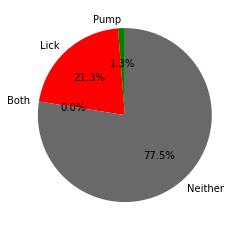

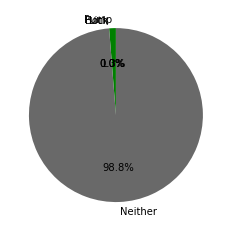

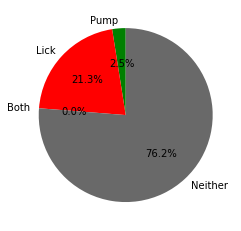

In [101]:
cas_lick_a, cas_lick_i,cas_pump_a, cas_pump_i=get_activated_cells(s2p_folder,events_file)

In [102]:
len(cas_lick_i)

0

## Casein PRNR 

In [103]:
animal="VGP302"
day="060"
date="20221212"
s2p_folder = "C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\Processed\\VGP_procd_data_22-12-05\\sub-{}\\ses-{}".format(animal, day)
events_file = "C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\Processed\\behav\\sub-{0}\\ses-{1}-{2}\\sub-{0}_ses-{1}_events.csv".format(animal, day, date)


11569
pump activated: [175, 207, 222]
pump inhibited: [40, 103]
lick activated: [119, 143, 147, 175, 187, 191, 194, 246, 259, 262, 268]
lick inhibited: [21, 85, 190, 204, 206, 276]
both activated: [175]
both inhibited: []
4 16 1 93
114


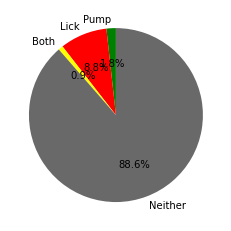

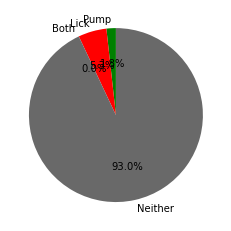

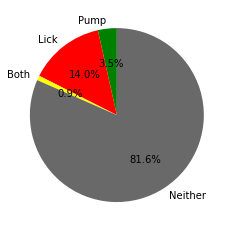

In [104]:
# cas_lick_PRNR,cas_pump_PRNR, cas_snips_PRNR=get_activated_cells(s2p_folder,events_file)
cas_lick_a_PRNR, cas_lick_i_PRNR,cas_pump_a_PRNR, cas_pump_i_PRNR=get_activated_cells(s2p_folder,events_file)

## Maltodextrine PR 

In [105]:
animal="VGP302"
day="029"
date="20221108"
s2p_folder = "C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\Processed\\VGP_procd_data_22-12-05\\sub-{}\\ses-{}".format(animal, day)
events_file = "C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\Processed\\behav\\sub-{0}\\ses-{1}-{2}\\sub-{0}_ses-{1}_events.csv".format(animal, day, date)

11518
pump activated: [0, 11, 31, 61, 70, 87, 89, 101]
pump inhibited: []
lick activated: [25, 41, 45, 61]
lick inhibited: [80]
both activated: [61]
both inhibited: []
7 4 1 53
65


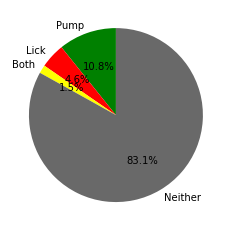

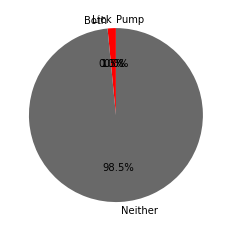

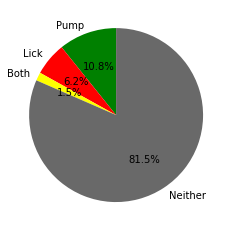

In [106]:
# malt_lick,malt_pump, malt_snips=get_activated_cells(s2p_folder,events_file)
malt_lick_a, malt_lick_i,malt_pump_a, malt_pump_i=get_activated_cells(s2p_folder,events_file)

## Maltodextrine PRNR

In [107]:
animal="VGP302"
day="063"
date="20221215"
s2p_folder = "C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\Processed\\VGP_procd_data_22-12-05\\sub-{}\\ses-{}".format(animal, day)
events_file = "C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\Processed\\behav\\sub-{0}\\ses-{1}-{2}\\sub-{0}_ses-{1}_events.csv".format(animal, day, date)

11322
pump activated: []
pump inhibited: [65, 112, 134]
lick activated: [4, 14, 18, 26, 37, 40, 48, 81]
lick inhibited: [122]
both activated: []
both inhibited: []
3 9 0 88
100


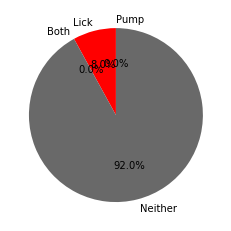

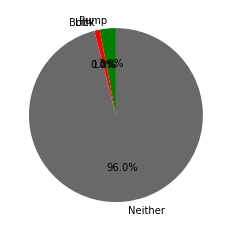

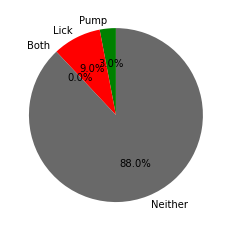

In [108]:
# malt_lick_PRNR,malt_pump_PRNR, malt_snips_PRNR=get_activated_cells(s2p_folder,events_file)
malt_lick_a_PRNR, malt_lick_i_PRNR,malt_pump_a_PRNR, malt_pump_i_PRNR=get_activated_cells(s2p_folder,events_file)

# Graphs 

## ALL

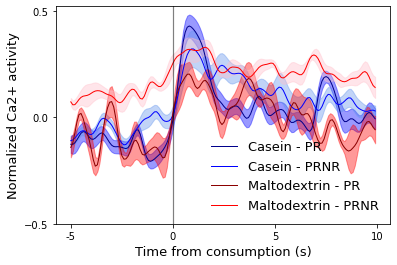

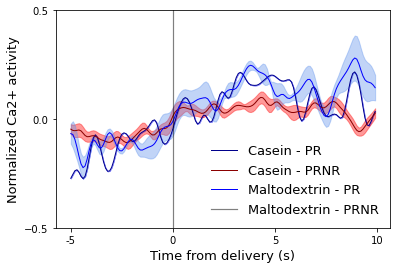

In [126]:
handles='Casein - PR', 'Casein - PRNR' ,'Maltodextrin - PR', 'Maltodextrin - PRNR'


fig2, ax2 = plt.subplots()
tp.shadedError(ax2, cas_lick_a,linecolor='darkblue',errorcolor='blue')
# tp.shadedError(ax2, cas_lick_i,linecolor='darkblue',errorcolor='blue')
tp.shadedError(ax2, cas_lick_a_PRNR, linecolor='blue', errorcolor='cornflowerblue')
# tp.shadedError(ax2, cas_lick_i_PRNR, linecolor='blue', errorcolor='cornflowerblue')


tp.shadedError(ax2, malt_lick_a, linecolor='darkred',errorcolor='red')
tp.shadedError(ax2, malt_lick_a_PRNR, linecolor='red', errorcolor='pink')
ax2.set_yticks([-0.5, 0,  0.5])
ax2.set_xticks([0,50,100,150])
ax2.set_xticklabels([-5,0,5,10])
ax2.axvline(50, color='black', alpha=0.5, linewidth=1.2)
ax2.legend(handles, fontsize=13,frameon = False)



fig3, ax3 = plt.subplots()


tp.shadedError(ax3, cas_pump_a, linecolor='darkblue', errorcolor='blue')
tp.shadedError(ax3, malt_pump_a, linecolor='darkred', errorcolor='red')
tp.shadedError(ax3, cas_pump_a_PRNR, linecolor='blue', errorcolor='cornflowerblue')
# tp.shadedError(ax2, malt_pump_a_PRNR, linecolor='red', errorcolor='pink')
ax3.set_yticks([-0.5, 0,  0.5])
ax3.set_xticks([0,50,100,150])
ax3.set_xticklabels([-5,0,5,10])
ax3.axvline(50, color='black', label='Pump on', alpha=0.5, linewidth=1.2)
ax3.legend(handles, fontsize=13,frameon = False)


ax2.set_ylabel('Normalized Ca2+ activity',fontsize = 13)
ax3.set_ylabel('Normalized Ca2+ activity',fontsize = 13)
ax2.set_xlabel('Time from consumption (s)', fontsize = 13)
ax3.set_xlabel('Time from delivery (s)', fontsize = 13)

fig2.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\signal-lick.png')
fig3.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\pump-lick.png')

## Casein PR and PRNR

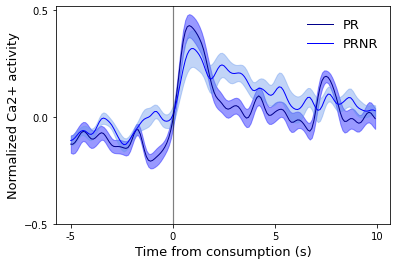

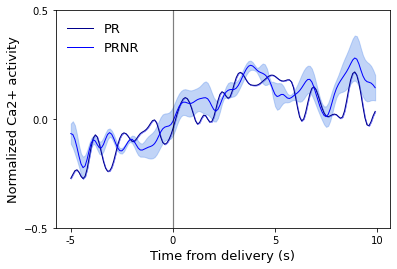

In [149]:
handles= 'PR', 'PRNR'

#Licks
fig1, ax1 = plt.subplots()
tp.shadedError(ax1, cas_lick_a, linecolor='darkblue',errorcolor='blue')
tp.shadedError(ax1, cas_lick_a_PRNR, linecolor='blue', errorcolor='cornflowerblue')
ax1.set_yticks([-0.5, 0,  0.5])
ax1.set_xticks([0,50,100,150])
ax1.set_xticklabels([-5,0,5,10])
ax1.axvline(50, color='black', alpha=0.5, linewidth=1.2)
ax1.legend(handles, fontsize=13,frameon = False)


#Pumps
fig2, ax2 =plt.subplots()
tp.shadedError(ax2, cas_pump_a, linecolor='darkblue',errorcolor='blue')
tp.shadedError(ax2, cas_pump_a_PRNR, linecolor='blue', errorcolor='cornflowerblue')

ax2.set_yticks([-0.5, 0,  0.5])
ax2.set_xticks([0,50,100,150])
ax2.set_xticklabels([-5,0,5,10])
ax2.axvline(50, color='black', alpha=0.5, linewidth=1.2)
ax2.legend(handles, fontsize=13,frameon = False)


ax1.set_ylabel('Normalized Ca2+ activity',fontsize = 13)
ax2.set_ylabel('Normalized Ca2+ activity',fontsize = 13)
ax1.set_xlabel('Time from consumption (s)', fontsize = 13)
ax2.set_xlabel('Time from delivery (s)', fontsize = 13)


fig1.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\signal_casein_lick.png')
fig2.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\signal_casein_pump.png')

## Maltodextrin PR and PRNR

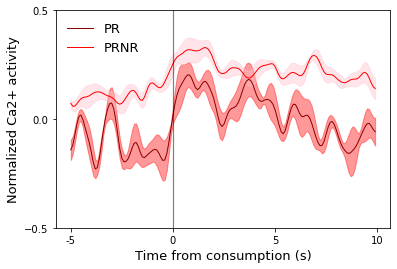

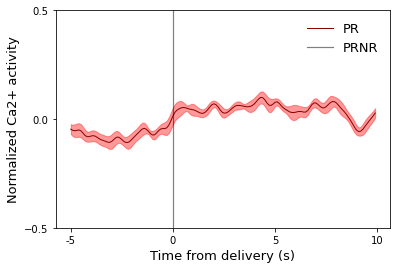

In [151]:
handles= 'PR', 'PRNR'

#Licks
fig1, ax1 = plt.subplots()
tp.shadedError(ax1, malt_lick_a, linecolor='darkred',errorcolor='red')
tp.shadedError(ax1, malt_lick_a_PRNR, linecolor='red', errorcolor='pink')
ax1.set_yticks([-0.5, 0,  0.5])
ax1.set_xticks([0,50,100,150])
ax1.set_xticklabels([-5,0,5,10])
ax1.axvline(50, color='black', alpha=0.5, linewidth=1.2)
ax1.legend(handles, fontsize=13,frameon = False)


#Pumps
fig2, ax2 =plt.subplots()
tp.shadedError(ax2, malt_pump_a, linecolor='darkred',errorcolor='red')
# tp.shadedError(ax2, malt_pump_a_PRNR, linecolor='blue', errorcolor='cornflowerblue')

ax2.set_yticks([-0.5, 0,  0.5])
ax2.set_xticks([0,50,100,150])
ax2.set_xticklabels([-5,0,5,10])
ax2.axvline(50, color='black', alpha=0.5, linewidth=1.2)
ax2.legend(handles, fontsize=13,frameon = False)


ax1.set_ylabel('Normalized Ca2+ activity',fontsize = 13)
ax2.set_ylabel('Normalized Ca2+ activity',fontsize = 13)
ax1.set_xlabel('Time from consumption (s)', fontsize = 13)
ax2.set_xlabel('Time from delivery (s)', fontsize = 13)


fig1.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\signal_malt_lick.png')
fig2.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\signal_malt_pump.png')


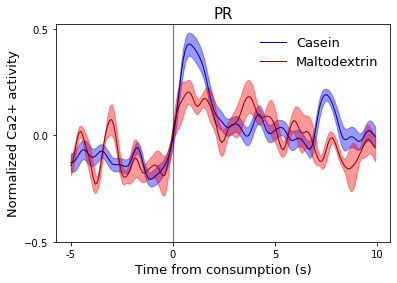

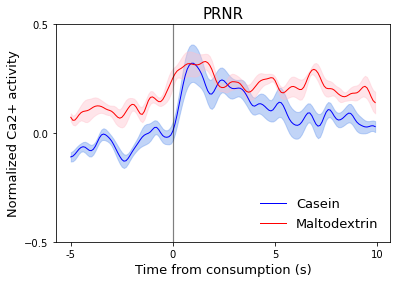

In [153]:
handles= 'Casein', 'Maltodextrin'

#Licks
fig1, ax1 = plt.subplots()
tp.shadedError(ax1, cas_lick_a, linecolor='darkblue',errorcolor='blue')
tp.shadedError(ax1, malt_lick_a, linecolor='darkred', errorcolor='red')
ax1.set_yticks([-0.5, 0,  0.5])
ax1.set_xticks([0,50,100,150])
ax1.set_xticklabels([-5,0,5,10])
ax1.axvline(50, color='black', alpha=0.5, linewidth=1.2)
ax1.legend(handles, fontsize=13,frameon = False)


#Pumps
fig2, ax2 =plt.subplots()
tp.shadedError(ax2, cas_lick_a_PRNR, linecolor='blue',errorcolor='cornflowerblue')
tp.shadedError(ax2, malt_lick_a_PRNR, linecolor='red', errorcolor='pink')

ax2.set_yticks([-0.5, 0,  0.5])
ax2.set_xticks([0,50,100,150])
ax2.set_xticklabels([-5,0,5,10])
ax2.axvline(50, color='black', alpha=0.5, linewidth=1.2)
ax2.legend(handles, fontsize=13,frameon = False)

ax1.set_title('PR', fontsize=15)
ax2.set_title('PRNR', fontsize=15)
ax1.set_ylabel('Normalized Ca2+ activity',fontsize = 13)
ax2.set_ylabel('Normalized Ca2+ activity',fontsize = 13)
ax1.set_xlabel('Time from consumption (s)', fontsize = 13)
ax2.set_xlabel('Time from consumption (s)', fontsize = 13)


fig1.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\signal_PR.png')
fig2.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\signal_PRNR.png')


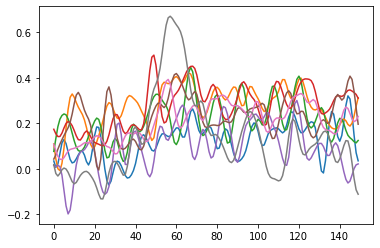

In [122]:
f, ax= plt.subplots()
for snip in malt_lick_a_PRNR: 
    ax.plot(snip)

In [ ]:
tp.shadedError?